<a href="https://colab.research.google.com/github/IvanWasNotAvailable/StockPricePrediction/blob/main/Sentiment140.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Imports

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

##0.1 Import Sentiment140 Dataset
The Sentiment140 dataset is a collection of 1.6 million tweets that have been tagged as either positive or negative.

In [2]:
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

--2022-12-10 11:35:25--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088192 (81M) [application/zip]
Saving to: ‘data/training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[===================>]  81.15M  32.7MB/s    in 2.5s    

2022-12-10 11:35:28 (32.7 MB/s) - ‘data/training.1600000.processed.noemoticon.csv.zip’ saved [85088192/85088192]

Archive:  data/training.1600000.processed.noemoticon.csv.zip
  inflating: data/training.1600000.processed.noemoticon.csv  


#1. Prep Work

In [3]:
#Read the tweets
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Update polarity

Right now the `polarity` column is `0` for negative, `4` for positive. We change that to `0` and `1` to make things a easier to read later.

In [4]:
df.polarity = df.polarity.replace({0: 0, 4: 1})
df.polarity.value_counts()

0    800000
1    800000
Name: polarity, dtype: int64

## Remove unneeded columns

In [5]:
df = df.drop(columns=['id', 'date', 'query', 'user'])
df.head(100)

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
95,0,Strider is a sick little puppy http://apps.fa...
96,0,"so rylee,grace...wana go steve's party or not?..."
97,0,"hey, I actually won one of my bracket pools! T..."
98,0,"@stark YOU don't follow me, either and i work..."


## Sample

To decrease the filesize and easier use we reduce the set to 100,000 tweets.

In [6]:
df = df.sample(n=100000)
df.polarity.value_counts()

0    50065
1    49935
Name: polarity, dtype: int64

#2. Training

With our Sample of Sentiment140 - a list of tweets along with a score as to whether they're negative or positive we'll build our own machine learning algorithm to see separate positivity from negativity.

##Info on Dataframe

In [7]:
df.shape

(100000, 2)

In [8]:
df.head()

,polarity,text
1470818,1,@daysdifference There are many songs i could...
992691,1,@jonmchu http://twitpic.com/5f70y - ahw. so cute
343505,0,"don't know what to do today, I wish it was sun..."
666873,0,yrbee abee a7l abe ad5'l al jam3a (( mta btn...
698842,0,@cullenboy 4 now. The visitors are getting her...


In [9]:
df.polarity.value_counts()

0    50065
1    49935
Name: polarity, dtype: int64

##Vectorize Tweets

Create a `TfidfVectorizer` and use it to vectorize our tweets. 
For easier use we use `max_features` to only take a selection (2k) of terms.

In [10]:
vectorizer = TfidfVectorizer(max_features=2000)
vectors = vectorizer.fit_transform(df.text)
words_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,09,10,100,11,12,13,14,15,...,your,youre,yours,yourself,youtube,yr,yrs,yum,yummy,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training our algorithm

### Setting up our variables

`X` is all of our **features**, the things we use to predict positive or negative. That's going to be our words.

`y` is all of our **labels**, the positive or negative rating. We'll use the `polarity` column for that.

In [11]:
X = words_df
y = df.polarity

###Choose Algorithm

We use **Linear-SVC** as our algorithm to train our data.

In [12]:
%%time
# Create and train a linear support vector classifier (LinearSVC)
svc = LinearSVC()
svc.fit(X, y)

CPU times: user 2.53 s, sys: 14.2 ms, total: 2.54 s
Wall time: 2.54 s


LinearSVC()

#4. Test Model



Now we are testing our Linear-SVC model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print("Training SVC")
svc.fit(X_train, y_train)

Training SVC


LinearSVC()

In [ ]:
y_true = y_test
y_pred = svc.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['negative', 'positive'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1), axis=0)

,Predicted negative,Predicted positive
Is negative,0.747103,0.252897
Is positive,0.213616,0.786384


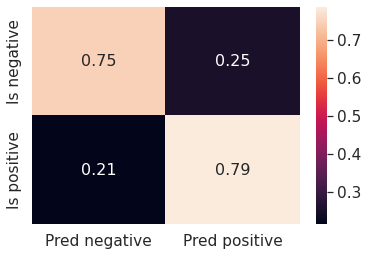

In [ ]:
df_cm = pd.DataFrame(matrix,
     columns='Pred ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1), axis=0)
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()

Is 75% accurracy good enough?